## Rozpoznawanie obrazu na przykładzie głębokiej sieci neuronowej na zbiorach MNIST, CIFAR-10 i danych Allegro

### MNIST - 60 tys. obrazków przedstawiających ręcznie napisane cyfry - 20x20 px
http://yann.lecun.com/exdb/mnist/

### CIFAR-10 - zbiór 60 tys. obrazków w rozmiarze 32x32 px, 10 kategorii - https://www.cs.toronto.edu/~kriz/cifar.html


prezentowany kod opracowany został przez Jasona Brownlee, Ph.D.:
http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

Pełną dokumentację kodu znajdziecie na stronie http://machinelearningmastery.com i w podręczniku "Deep Learning with Python" (dostępny za opłatą na stronie)

Using TensorFlow backend.


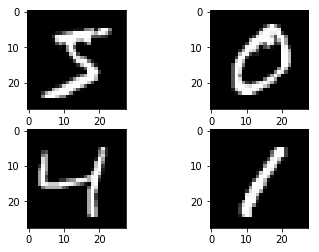

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray')) 
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray')) 
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray')) 
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.show()


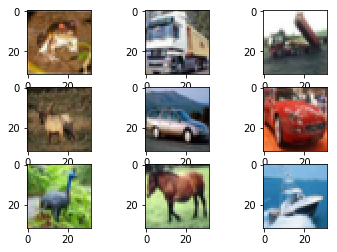

In [2]:
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
# load data
(X_train_cf, y_train_cf), (X_test_cf, y_test_cf) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(X_train_cf[i]))
# show the plot
pyplot.show()

aby nauczyć naszą sieć rozpoznawania obrazu skorzystamy z warstw konwolucyjnych = aktywowanych losowo filtrów prostych cech obrazu, skorzystamy też z warstw typu pooling aby wydobyć najsilniejszy sygnał z kolejnych warstw sieci

będziemy chcieli zbudować coś takiego:

![architektura_sieci](img/network_arch.png)



każdy obrazek można przestawić w postaci macierzy wartości, np. natężenie szarości dla obrazka czarno-białego

![obrazek_jako_matrix](img/data_matrix.gif)

jeśli wyobrazimy sobie nasz obrazek jako pewną macierz (np. dla jednego kanału)

![macierz](img/matrix1.png)

i filtr wyglądający następująco

![macierz](img/filter.png)

to tworzenie mapy cech macierzy z wykorzystaniem filtra będzie wyglądała następująco:

![tworzenie_mapy_cech](img/convolution_schematic.gif)

źródło: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/




dla jednego obrazka możemy zbudować wiele map cech korzystając z różnych filtrów

![mapy_cech](img/feature_maps.gif)


aby nie przeuczyć sieci i zredukować liczbę parametrów / ilość informacji przesyłanych do kolejnych warstw korzystamy z tzw. pooling layers, najczęściej jest to maxpooling

![maxpooling](img/maxpool.png)



Cały proces trenowania sieci neuronowej z warstwami konwolucji będzie wyglądał następująco:

![deep_model](img/deep_model.png)

Krok1: Inicjujemy filtry i połączenia losowymi wartościami.

Krok2: Sieć bierze mini-batch obrazków i przepuszcza przez losowo aktywowane warstwy, w efekcie wylicza prawdpodobieństwa dla kategorii. Ponieważ wagi inicjowane są losowo to wynik w pierwszym przeliczeniu prawdopodobieńsw też będzie losowy. 

Krok3: Wyliczamy błąd klasyfikacji na wyjściu.

Krok4: Korzystając z algorytmu wstecznej propagacji błędu wyliczane są gradienty błędu w odniesieniu do wszystkich wag w sieci i korzystając z optymalizacyjnej metody największego spadku są modyfikowane w celu zminimalizowania funkcji błędu. 

Wagi są aktulizowane proporcjonalnie do ich siły wpływu na błąd/ 

Parametry takie jak liczba filtrów, wielkości filtrów, topologia sieci nie są zmieniane w trakcie uczenia, jedyne co ulega zmianie to wagi filtrów i połączeń. 

Krok5: Powtórz kroki 2-4 dla wszystkich obrazków x liczba epok 


![keras_tensorflow](img/keras-tensorflow-logo.jpg)

Tensorflow - silnik open source opracowany przez inżynierów Google służący do operacji numerycznych w architekturze grafów przepływu danych (dataflow graphs)

![tensorflow](img/tensorflow-1.png)


Keras - wysokopoziomowe API pozwalające na szybkie prototypowanie głębokich sieci z wykorzystaniem Tensorlow lub Keras (http://keras.io)





# ZACZNIJMY OD CZEGOŚ PROSTEGO - ZWYKŁA SIEĆ DO KLASYFIKACJI NA ZBIORZE PIMA INDIANS DIABETES

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy
import pandas as pd
from keras.callbacks import History

seed = 7
numpy.random.seed(seed)
#ładujemy dane
dataset = numpy.loadtxt("data/pima-indians-diabetes.csv", delimiter=",")


In [4]:
pd.DataFrame(dataset).sample(10)

0      1     2     3      4     5      6     7    8
353   1.0   90.0  62.0  12.0   43.0  27.2  0.580  24.0  0.0
236   7.0  181.0  84.0  21.0  192.0  35.9  0.586  51.0  1.0
323  13.0  152.0  90.0  33.0   29.0  26.8  0.731  43.0  1.0
98    6.0   93.0  50.0  30.0   64.0  28.7  0.356  23.0  0.0
701   6.0  125.0  78.0  31.0    0.0  27.6  0.565  49.0  1.0
61    8.0  133.0  72.0   0.0    0.0  32.9  0.270  39.0  1.0
600   1.0  108.0  88.0  19.0    0.0  27.1  0.400  24.0  0.0
242   3.0  139.0  54.0   0.0    0.0  25.6  0.402  22.0  1.0
744  13.0  153.0  88.0  37.0  140.0  40.6  1.174  39.0  0.0
644   3.0  103.0  72.0  30.0  152.0  27.6  0.730  27.0  0.0

In [5]:
dataset.shape

(768, 9)

In [6]:
#wybieramy predytkory i zmienną uczącą
X = dataset[:,0:8]
Y = dataset[:,8]
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed) # create model

model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 221.0
Trainable params: 221
Non-trainable params: 0.0
_________________________________________________________________


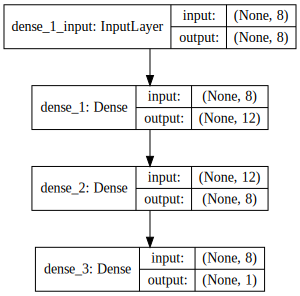

In [7]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

In [8]:
hist_model = History()

#uczymy model
model.fit(X_train, y_train, validation_data=(X_test,y_test), nb_epoch=200, batch_size=10, verbose=2, callbacks=[hist_model])

/Users/mikolaj.sedek/miniconda3/envs/py3deep/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 614 samples, validate on 154 samples
Epoch 1/200
0s - loss: 0.6879 - acc: 0.6173 - val_loss: 0.6833 - val_acc: 0.6299
Epoch 2/200
0s - loss: 0.6684 - acc: 0.6564 - val_loss: 0.6716 - val_acc: 0.6299
Epoch 3/200
0s - loss: 0.6593 - acc: 0.6580 - val_loss: 0.6659 - val_acc: 0.6364
Epoch 4/200
0s - loss: 0.6525 - acc: 0.6564 - val_loss: 0.6558 - val_acc: 0.6299
Epoch 5/200
0s - loss: 0.6434 - acc: 0.6564 - val_loss: 0.6370 - val_acc: 0.6364
Epoch 6/200
0s - loss: 0.6337 - acc: 0.6726 - val_loss: 0.6217 - val_acc: 0.6753
Epoch 7/200
0s - loss: 0.6216 - acc: 0.6726 - val_loss: 0.6226 - val_acc: 0.7273
Epoch 8/200
0s - loss: 0.6133 - acc: 0.6873 - val_loss: 0.6464 - val_acc: 0.6299
Epoch 9/200
0s - loss: 0.6174 - acc: 0.6547 - val_loss: 0.6259 - val_acc: 0.6364
Epoch 10/200
0s - loss: 0.6067 - acc: 0.6694 - val_loss: 0.5941 - val_acc: 0.7468
Epoch 11/200
0s - loss: 0.5999 - acc: 0.6840 - val_loss: 0.5825 - val_acc: 0.7532
Epoch 12/200
0s - loss: 0.5927 - acc: 0.6922 - val_loss: 0.61

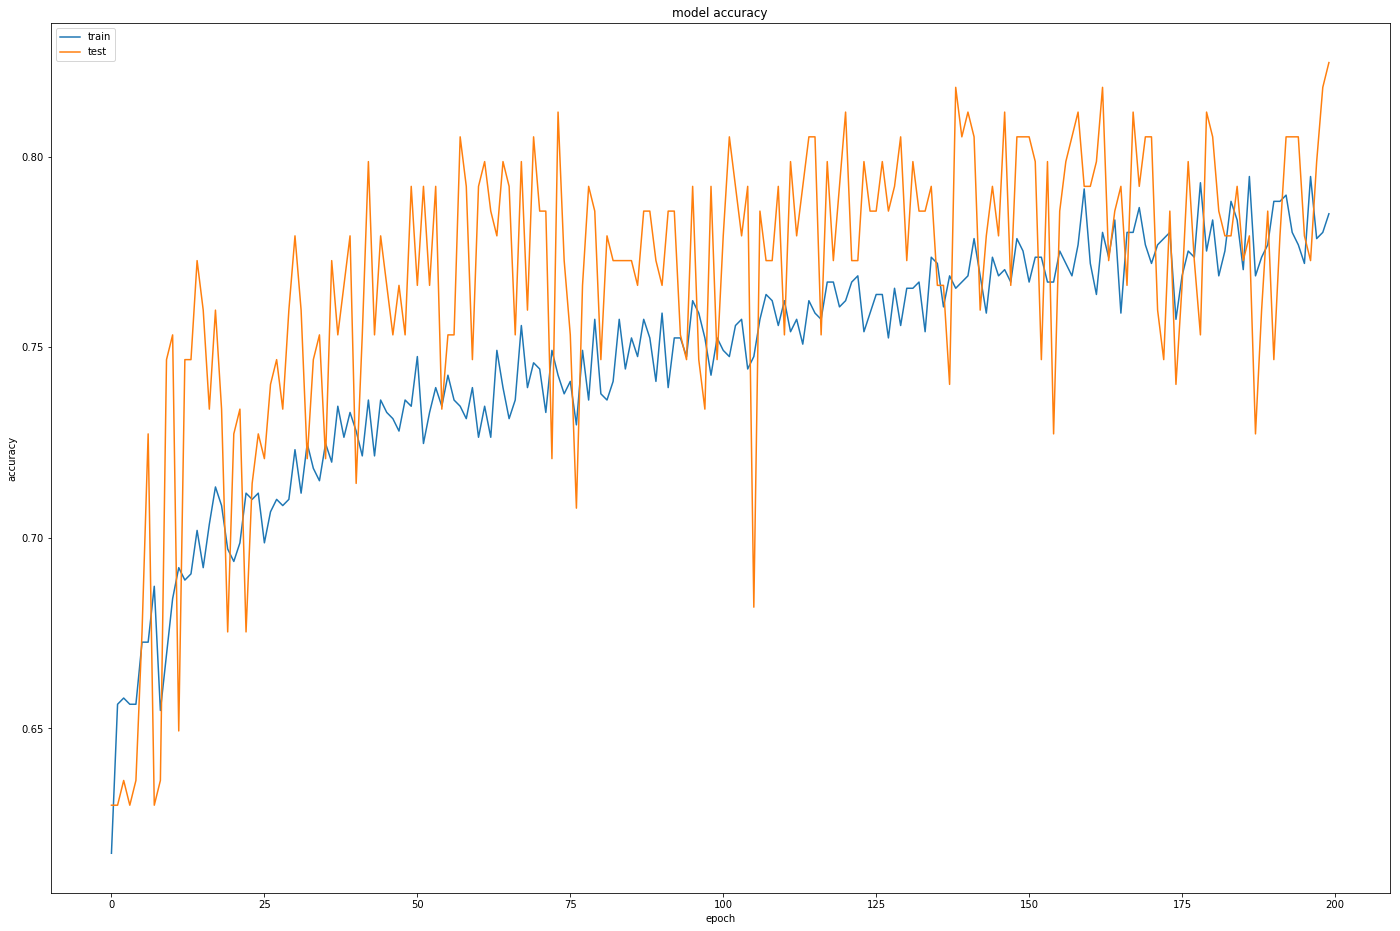

In [10]:
import matplotlib.pyplot as plt

plt.plot(hist_model.history['acc'])
plt.plot(hist_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.rcParams["figure.figsize"] = (24,16)
plt.show()


# SIEĆ DO ROZPOZNAWANIA RĘCZNIE PISANYCH CYFR - zbiór MNIST

In [1]:
#przygotujmy sieć do rozpoznawania ręcznie pisanych cyfr 

# przygotowanie modułów i danych
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from keras.callbacks import History

K.set_image_dim_ordering('tf')



Using TensorFlow backend.


In [2]:
# ustawienie seed dla generatorów liczb pseudolosowych zadziała poprawnie tylko w przypadku korzystania z CPU
seed = 1
numpy.random.seed(seed)
# ładujemy dane
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


In [3]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# definiujemy model z warstwami konwolucji i maxpooling
def model_mnist():
	# create model
	model = Sequential()
	model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Conv2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))

	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

model = model_mnist()


In [ ]:
model.summary()

In [ ]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

In [ ]:
hist_model = History()

#uczymy model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2, callbacks = [hist_model])
# ewaluacja modelu na zbiorze testowym
scores = model.evaluate(X_test, y_test, verbose=0)
print("Błąd na zbiorze testowym: %.2f%%" % (100-scores[1]*100))


In [ ]:
#narysjmy historię uczenia

import matplotlib.pyplot as plt

plt.plot(hist_model.history['acc'])
plt.plot(hist_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.rcParams["figure.figsize"] = (24,16)
plt.show()


Jak wygląda klasyfikacja nowego obrazka dla sieci tego typu (przejście danych przez warstwy konwolucyjne i w pełni połączone):
http://scs.ryerson.ca/~aharley/vis/conv/


# SIEĆ DO ROZPOZNAWANIA OBRAZKÓW- zbiór CIFAR-10

In [ ]:
# to zacznijmy proces uczenia sieci

import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import TensorBoard

K.set_image_dim_ordering('tf')




In [ ]:
# jeśli korzystamy z CPU to można ustawić seed, przy GPU nie ma możliwości na zapewnienie identycznych warunków
seed = 7
numpy.random.seed(seed)
# ładujemy dane
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# normalizacja wartości
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0
# kodowanie zmiennych celu
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print("liczba kategorii do predykcji to: "+str(num_classes))


In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# Definiujemy model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Kompilujemy model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [ ]:
#zobaczmy graf naszego modelu

print(model.summary())

In [ ]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

In [ ]:
# uczenie modelu
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128, verbose=2)
# wynik modelu na danych testowych
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

### Krótka instrukcja jak odpalić ten notebook na własnym komputerze
Zalecane systemy: Mac OS lub Ubuntu

1. Instalujemy Py 3.6 w dystrybucji Anaconda https://www.continuum.io/downloads lub stawiamy virtual env za pomocą Minicondy
2. Instalujemy keras i tensorflow z konsoli*: pip install keras tensorflow
3. Aby działała wizualizacja sieci (użytkownicy Mac OS mogą użyć brew):
sudo apt-get install graphviz
sudo pip install pydot==1.0.2 --upgrade
4. Wchodzimy do katalogi z notebookiem i wywołujemy Jupytera w konsoli: jupyter notebook

*jeśli mamy komputer z mocną NVidią na pokładzie i chcemy korzystać z GPU zalecam lekturę tego bloga:
http://ksopyla.com/python/tensorflow/instalacja-tensorflow-r0-12-cuda-8-ubuntu-16/



# Zalecana literatura

https://github.com/HFTrader/DeepLearningBook
![deepLearnbook](img/book1.jpg)

![deepLearningPython](img/book2.jpg)

![machineLearningPython](img/book3.jpg)

### fantastyczne notebooki w Jupyter: 
https://github.com/jakevdp/PythonDataScienceHandbook <br\>
https://github.com/leriomaggio/deep-learning-keras-tensorflow
